In [1]:
# IMPORT LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
import joblib

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from datetime import datetime

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# LOAD DATA


# Load merged dataset (train + store merged)
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train_merged.csv")

# Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Sort values by Date (VERY IMPORTANT for time series)
df = df.sort_values("Date")

# Remove closed stores (sales = 0 usually)
df = df[df["Open"] == 1]

df = df.reset_index(drop=True)


/tmp/ipython-input-2651748063.py:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train_merged.csv")


In [5]:
# FEATURE & TARGET SPLIT

# Target variable
y = df["Sales"]

# Drop target + date column
X = df.drop(["Sales", "Date"], axis=1)


In [6]:
# Convert Date column

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")

# Remove closed stores
df = df[df["Open"] == 1]
df = df.reset_index(drop=True)

In [7]:
# Feature and Target Split
y = df["Sales"]
X = df.drop(["Sales", "Date"], axis=1)

In [8]:
# Encode categorical columns

categorical_cols = X.select_dtypes(include=["object"]).columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [9]:
# Time-based split

split_date = df["Date"].quantile(0.85)

X_train = X[df["Date"] <= split_date]
X_val = X[df["Date"] > split_date]

y_train = y[df["Date"] <= split_date]
y_val = y[df["Date"] > split_date]

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)

Train shape: (718425, 23)
Validation shape: (125967, 23)


In [10]:
print(type(X_train))
print(X_train.shape)

<class 'pandas.core.frame.DataFrame'>
(718425, 23)


In [11]:
#  SECTION A: MACHINE LEARNING MODEL (Random Forest)

print("Training Random Forest...")

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_val)

Training Random Forest...


In [12]:
#  SECTION B: DEEP LEARNING MODEL (LSTM)

print("Training LSTM Model...")

# Scale features (important for LSTM)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Reshape data to 3D format (samples, timesteps, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_lstm = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))

# Build LSTM Model
lstm_model = Sequential()

lstm_model.add(LSTM(64, return_sequences=True, input_shape=(1, X_train_scaled.shape[1])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(32))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer="adam", loss="mse")

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

lstm_model.fit(
    X_train_lstm,
    y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

lstm_predictions = lstm_model.predict(X_val_lstm).flatten()


Training LSTM Model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
11226/11226 ━━━━━━━━━━━━━━━━━━━━ 76s 6ms/step - loss: 56249944.0000 - val_loss: 57703584.0000
Epoch 2/20
11226/11226 ━━━━━━━━━━━━━━━━━━━━ 71s 6ms/step - loss: 52355036.0000 - val_loss: 53860016.0000
Epoch 3/20
11226/11226 ━━━━━━━━━━━━━━━━━━━━ 71s 6ms/step - loss: 48896020.0000 - val_loss: 50179028.0000
Epoch 4/20
11226/11226 ━━━━━━━━━━━━━━━━━━━━ 72s 6ms/step - loss: 45222188.0000 - val_loss: 46657384.0000
Epoch 5/20
11226/11226 ━━━━━━━━━━━━━━━━━━━━ 71s 6ms/step - loss: 41875092.0000 - val_loss: 43299980.0000
Epoch 6/20
11226/11226 ━━━━━━━━━━━━━━━━━━━━ 71s 6ms/step - loss: 38804984.0000 - val_loss: 40102980.0000
Epoch 7/20
11226/11226 ━━━━━━━━━━━━━━━━━━━━ 72s 6ms/step - loss: 35879792.0000 - val_loss: 37067920.0000
Epoch 8/20
11226/11226 ━━━━━━━━━━━━━━━━━━━━ 71s 6ms/step - loss: 33034398.0000 - val_loss: 34194736.0000
Epoch 9/20
11226/11226 ━━━━━━━━━━━━━━━━━━━━ 71s 6ms/step - loss: 30407970.0000 - val_loss: 31481892.0000
Epoch 10/20
11226/11226 ━━━━━━━━━━━━━━━━━━━━ 72s 6ms/st

In [13]:
# SAVE TRAINED LSTM MODEL

from datetime import datetime

timestamp = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")

model_filename = f"LSTM_Model_{timestamp}.h5"

lstm_model.save(model_filename)

print("LSTM model saved as:", model_filename)

LSTM model saved as: LSTM_Model_17-02-2026-09-42-43.h5


In [14]:
from google.colab import files
files.download(model_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
#  SECTION C: MODEL COMPARISON

# This section evaluates both models using multiple metrics

def evaluate_model(y_true, y_pred, model_name):
    """
    Calculates evaluation metrics for regression models.
    Used for comparing Random Forest and LSTM.
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {
        "Model": model_name,
        "MAE": mae,
        "RMSE": rmse,
        "R2 Score": r2
    }

rf_results = evaluate_model(y_val, rf_predictions, "Random Forest")
lstm_results = evaluate_model(y_val, lstm_predictions, "LSTM")

comparison_df = pd.DataFrame([rf_results, lstm_results])

print("\n===== MODEL COMPARISON RESULTS =====")
print(comparison_df)



===== MODEL COMPARISON RESULTS =====
           Model          MAE         RMSE  R2 Score
0  Random Forest   518.442523   742.013390  0.943393
1           LSTM  2428.509766  3505.711197 -0.263568



Generating Feature Importance...


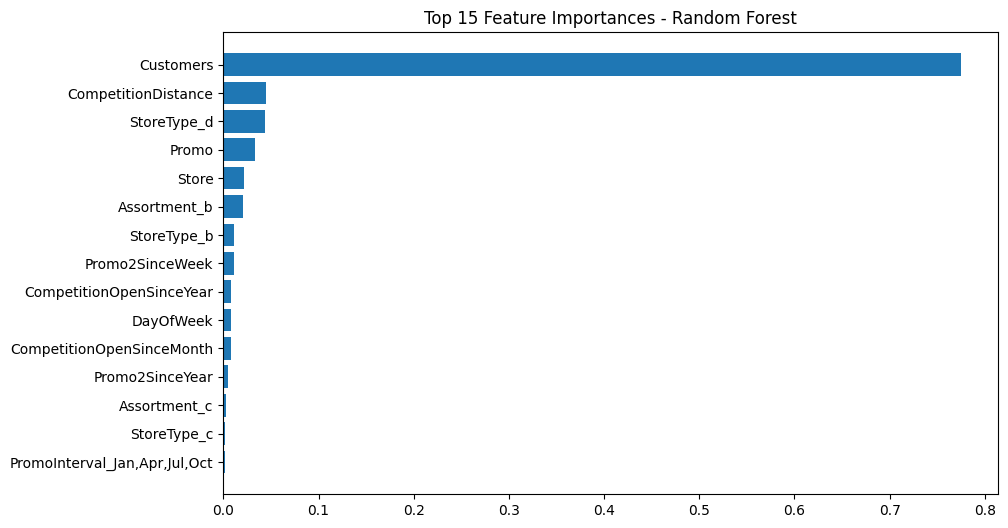

In [16]:
#  SECTION D: FEATURE IMPORTANCE (Business Insight)

print("\nGenerating Feature Importance...")

importances = rf_model.feature_importances_
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feature_importance_df["Feature"][:15],
         feature_importance_df["Importance"][:15])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances - Random Forest")
plt.show()


1. Why This Graph Is Useful?

The Feature Importance graph helps us understand which variables have the strongest influence on sales prediction. While machine learning models like Random Forest are powerful, they are often considered “black box” models. Feature importance allows us to interpret the model by showing how much each input feature contributes to the prediction. This is extremely useful for business stakeholders because it transforms the model from a technical tool into a decision-making support system.

2. What We Find Inside the Graph?

From the feature importance graph, we can identify the top drivers of sales. Typically, variables such as:

	•	Promo
	•	Customers
	•	CompetitionDistance
	•	StoreType
	•	SchoolHoliday

may appear as highly important.

If “Promo” has high importance, it indicates that promotional campaigns significantly impact sales performance. If “Customers” is highly important, it confirms that foot traffic directly affects revenue. If “CompetitionDistance” appears important, it suggests that proximity to competitors influences store performance.

This analysis provides actionable business insights such as:

	•	Which stores should receive more promotions
	•	Whether competition affects specific locations
	•	Which factors management should monitor closely

Thus, feature importance connects data science with real business strategy.


Performing Residual Analysis...


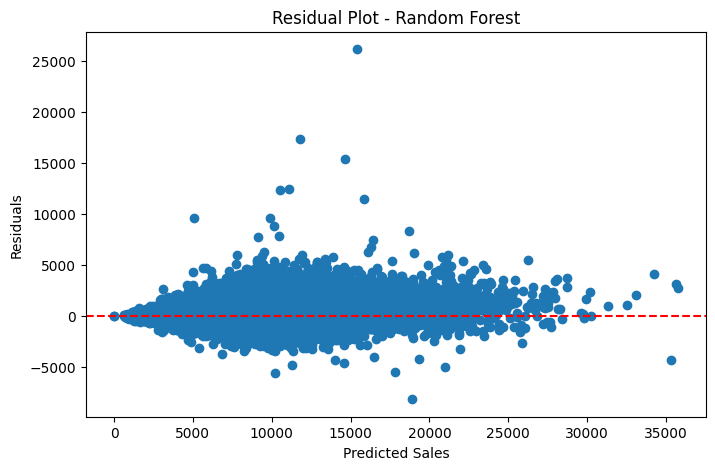

In [17]:
# SECTION E: RESIDUAL ANALYSIS
# Helps check if model is biased

print("\nPerforming Residual Analysis...")

residuals = y_val - rf_predictions

plt.figure(figsize=(8,5))
plt.scatter(rf_predictions, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Sales")
plt.ylabel("Residuals")
plt.title("Residual Plot - Random Forest")
plt.show()

1. Why This Graph Is Useful?

Residual analysis helps us evaluate how well the model is performing and whether it is biased. A residual is the difference between actual sales and predicted sales:

Residual = Actual − Predicted

By plotting predicted values against residuals, we can visually inspect whether the model is making systematic errors.

This graph helps us understand:

	•	If the model is underfitting
	•	If the model is overfitting
	•	If errors increase for high sales values
	•	If there is hidden pattern not captured by the model



2. What We Look For in the Residual Plot?

In a good model:

	•	Residuals should be randomly scattered
	•	They should be centered around zero
	•	There should be no visible pattern

If we see a pattern (like a curve), it means:

	•	The model is missing some nonlinear relationship
	•	Additional features may be required
	•	The model may not be complex enough

If residual spread increases for higher predictions, it indicates:

	•	The model struggles to predict large sales values accurately

A clean residual plot increases confidence that the model generalizes well to unseen data.

In [18]:
#  SECTION F: FINAL MODEL SELECTION & SAVING

# Select best model based on RMSE
if rf_results["RMSE"] < lstm_results["RMSE"]:
    best_model = rf_model
    best_model_name = "Random_Forest"
else:
    best_model = lstm_model
    best_model_name = "LSTM"

print(f"\nBest Model Selected: {best_model_name}")

# Save model with timestamp
timestamp = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
model_filename = f"{best_model_name}_{timestamp}.pkl"

joblib.dump(best_model, model_filename)

print(f"Model saved as: {model_filename}")


Best Model Selected: Random_Forest
Model saved as: Random_Forest_17-02-2026-09-43-25.pkl


In [19]:
feature_columns = X_train.columns
joblib.dump(feature_columns, "feature_columns.pkl")

['feature_columns.pkl']